In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import scipy.stats
import scipy.stats as sps

In [110]:
data = pd.read_excel('card transactions.xlsx', engine='openpyxl', converters={'Merchnum' : lambda x:str(x)})

In [111]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96753 entries, 0 to 96752
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Recnum             96753 non-null  int64         
 1   Cardnum            96753 non-null  int64         
 2   Date               96753 non-null  datetime64[ns]
 3   Merchnum           93378 non-null  object        
 4   Merch description  96753 non-null  object        
 5   Merch state        95558 non-null  object        
 6   Merch zip          92097 non-null  float64       
 7   Transtype          96753 non-null  object        
 8   Amount             96753 non-null  float64       
 9   Fraud              96753 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(4)
memory usage: 7.4+ MB


In [112]:
# remove outliers
m = data['Amount'].mean()
s = data['Amount'].std()
lb = m-5*s
ub = m+5*s
data[(data['Amount']<lb) | (data['Amount']>ub)]

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
52714,52715,5142189135,2010-07-13,NaN,INTERMEXICO,NaN,NaN,P,3102045.53,0


In [113]:
data.drop([52714], axis=0, inplace=True)

In [114]:
# remove transaction types not equal 'P'
data = data[data['Transtype']=='P']

In [115]:
# notice that
data[data['Merch description']=='0000000000000000000000']

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
83923,83924,5142182645,2010-10-28,8168600400097,0000000000000000000000,WA,98052.0,P,463.86,0
92542,92543,5142185554,2010-12-10,8168600400097,0000000000000000000000,WA,98052.0,P,127.87,0
92570,92571,5142185554,2010-12-10,8168600400097,0000000000000000000000,WA,98052.0,P,769.70,0


In [116]:
data1 = data.copy()

## Filling missing values

In [117]:
data.isna().sum()

Recnum                  0
Cardnum                 0
Date                    0
Merchnum             3198
Merch description       0
Merch state          1020
Merch zip            4300
Transtype               0
Amount                  0
Fraud                   0
dtype: int64

In [118]:
# Merch num:
# groupby description and use the mode
# if no description avaliable, fill by 'unknown'

In [119]:
data['Merchnum'] = data['Merchnum'].fillna(data.groupby(['Merch description'])['Merchnum'] \
                        .transform(lambda x:x.mode()[0] if x.mode().empty==False else np.NaN))

In [120]:
data.isna().sum()

Recnum                  0
Cardnum                 0
Date                    0
Merchnum             2038
Merch description       0
Merch state          1020
Merch zip            4300
Transtype               0
Amount                  0
Fraud                   0
dtype: int64

In [121]:
data['Merch zip'] = data['Merch zip'].fillna(data.groupby(['Merch description'])['Merch zip'] \
                        .transform(lambda x:x.mode()[0] if x.mode().empty==False else np.NaN))

In [122]:
data.isna().sum()

Recnum                  0
Cardnum                 0
Date                    0
Merchnum             2038
Merch description       0
Merch state          1020
Merch zip            2043
Transtype               0
Amount                  0
Fraud                   0
dtype: int64

In [123]:
data['Merch state'] = data['Merch state'].fillna(data.groupby(['Merch description'])['Merch state'] \
                        .transform(lambda x:x.mode()[0] if x.mode().empty==False else np.NaN))

In [124]:
data.isna().sum()

Recnum                  0
Cardnum                 0
Date                    0
Merchnum             2038
Merch description       0
Merch state           363
Merch zip            2043
Transtype               0
Amount                  0
Fraud                   0
dtype: int64

In [125]:
# Merch zip & state

In [126]:
ns = data['Merch state'].isnull()
nsi = ns[ns==True].index
sum(data.loc[nsi,'Merch zip'].isnull())

269

When 'Merch state' is NaN, usually 'Merch zip' is NaN as well

In [127]:
sum(data['Merch zip'].isnull())

2043

In [128]:
nz = data['Merch zip'].isnull()
nzi = ns[ns==True].index
sum(data.loc[nzi,'Merch state'].isnull())

363

When 'Merch zip' is NaN, not as much 'Merch state' is NaN

Thus, we first fill 'Merch state' using 'Merch zip' and 'Merch description',
and then use 'Merch state' to fill missing 'Merch zip'

In [129]:
# Merch state
# first group by existing zipcode

In [130]:
# find all rows where zip is not NaN for missing state
d = data[(data['Merch state'].isnull()==True) & (data['Merch zip'].isnull()==False)]
d

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
3258,3259,5142153880,2010-01-14,582582822587,DIGITAL TECHNOLOGY CONTRA,NaN,926.0,P,2340.00,0
3262,3263,5142154098,2010-01-14,582582822587,DIGITAL TECHNOLOGY CONTRA,NaN,926.0,P,2387.00,0
3540,3541,5142154098,2010-01-17,582582822587,DIGITAL TECHNOLOGY CONTRA,NaN,926.0,P,2300.00,0
3642,3643,5142153880,2010-01-17,582582822587,DIGITAL TECHNOLOGY CONTRA,NaN,926.0,P,2500.00,0
4969,4970,5142194136,2010-01-24,597597721468,CRISTALIA ACQUISITION COR,NaN,929.0,P,83.00,0
...,...,...,...,...,...,...,...,...,...,...
83272,83273,5142193384,2010-10-26,600555303209,EMBASSY SUITES PR,NaN,38117.0,P,300.00,0
83425,83426,5142193384,2010-10-27,600555303209,EMBASSY SUITES PR,NaN,38117.0,P,600.00,0
83454,83455,5142193384,2010-10-27,600555303209,EMBASSY SUITES PR,NaN,38117.0,P,600.00,0
86405,86406,5142194136,2010-11-10,7007631331,AAFES BUCHANAN MAIN STR,NaN,934.0,P,184.41,0


In [131]:
# find matching state for zip
z_to_s = {}
for z in d['Merch zip'].unique():
    dz = data.loc[data['Merch zip']==z,'Merch state']
    if dz.mode().empty == True:
        s = np.NaN
    else:
        s = dz.mode()[0]
    z_to_s.update({z:s})
z_to_s

{926.0: nan,
 929.0: nan,
 1400.0: nan,
 65132.0: nan,
 86899.0: nan,
 23080.0: nan,
 60528.0: nan,
 6.0: 'IL',
 934.0: nan,
 738.0: nan,
 2.0: 'MD',
 90805.0: nan,
 76302.0: nan,
 9.0: 'CA',
 914.0: nan,
 95461.0: nan,
 50823.0: nan,
 48700.0: nan,
 680.0: nan,
 1.0: 'PA',
 681.0: nan,
 623.0: nan,
 726.0: nan,
 936.0: nan,
 12108.0: nan,
 791.0: nan,
 907.0: nan,
 922.0: nan,
 920.0: nan,
 3.0: 'GA',
 801.0: nan,
 8.0: 'CO',
 31040.0: nan,
 38117.0: 'TN',
 41160.0: nan}

In [132]:
for index in d.index:
    data.loc[index,'Merch state'] = z_to_s[data.loc[index,'Merch zip']]

In [133]:
sum(data['Merch state'].isnull())

335

reduce from 1200 down to 1000

In [134]:
# then group by Merch description & Merch zip, use the mode
# if no available zip or description, fill by 'unknown'
data['Merch state'] = data['Merch state'].fillna(data.groupby(['Merch description'])['Merch state'] \
                        .transform(lambda x:x.mode()[0] if x.mode().empty==False else 'unknown'))

In [135]:
sum(data['Merch state'].isnull())

0

In [136]:
# Merch zip
# group by Merch state and use the mode
data['Merch zip'] = data['Merch zip'].fillna(data.groupby(['Merch state'])['Merch zip'] \
                        .transform(lambda x:x.mode()[0] if x.mode().empty==False else 'unknown'))

In [137]:
sum(data['Merch zip'].isnull())

0

In [138]:
# total how many unknowns

In [139]:
len(data[data['Merchnum']=='unknown'])

0

In [140]:
len(data[data['Merch state']=='unknown'])

335

In [141]:
len(data[data['Merch zip']=='unknown'])

40

In [142]:
len(data[(data['Merchnum']=='unknown') & (data['Merch state']=='unknown') & (data['Merch zip']=='unknown')])

0

In [143]:
len(data[(data['Merchnum']=='unknown') & (data['Merch state']=='unknown')])

0

In [144]:
len(data[(data['Merchnum']=='unknown') & (data['Merch zip']=='unknown')])

0

In [145]:
data.isna().sum()

Recnum                  0
Cardnum                 0
Date                    0
Merchnum             2038
Merch description       0
Merch state             0
Merch zip               0
Transtype               0
Amount                  0
Fraud                   0
dtype: int64

In [146]:
data = data.replace(np.nan,'unknown')

In [147]:
data.isna().sum()

Recnum               0
Cardnum              0
Date                 0
Merchnum             0
Merch description    0
Merch state          0
Merch zip            0
Transtype            0
Amount               0
Fraud                0
dtype: int64

In [39]:
data.to_csv('data_cleaned.csv')

In [86]:
data.shape

(96397, 13)

### Feature Engineering

In [148]:
data['Cardnum']=data['Cardnum'].astype(str)
data['Merchnum']=data['Merchnum'].astype(str)
data['Merch zip']=data['Merch zip'].astype(str)
data['card_merchnum']=data.Cardnum+data.Merchnum
data['card_zip']=data.Cardnum+data['Merch zip']
data['card_state']=data.Cardnum+data['Merch state']

In [149]:
attributes=['Cardnum','Merchnum','card_merchnum','card_zip','card_state']

In [150]:
df1 = data.copy()
final = data.copy()
df1['check_date'] = df1.Date
df1['check_record'] = df1.Recnum

In [151]:
import datetime as dt

In [152]:

for entity in attributes:
    df_1 = df1[['Recnum','Date',entity]]
    df_r = df1[['check_record','check_date',entity,'Amount']]
    temp = pd.merge(df_1,df_r,left_on=entity,right_on=entity)
    #day since
    day_since_df = temp[temp.Recnum > temp.check_record][['Recnum','Date','check_date']]\
        .groupby('Recnum')[['Date','check_date']].last()
    mapper = (day_since_df.Date - day_since_df.check_date).dt.days
    final[entity + '_day_since'] = final.Recnum.map(mapper)
    final[entity + '_day_since'].fillna(365,inplace=True)
    
    
    for offset_t in [0,1,3,7,14,30]:
        #frequency variable
        count_day_df = temp[(temp.check_date >= (temp.Date - dt.timedelta(offset_t)))
                           & (temp.Recnum >= temp.check_record)]
        col_name = f'{entity}_count_{offset_t}'
        mapper2 = count_day_df.groupby('Recnum')[entity].count()
        final[col_name] = final.Recnum.map(mapper2)
        #amount mean variable
        count_day_df = temp[(temp.check_date >= (temp.Date - dt.timedelta(offset_t)))
                           & (temp.Recnum >= temp.check_record)]
        col_name = f'ave_amount_{entity}_count_{offset_t}'
        mapper3 = count_day_df.groupby(entity)['Amount'].mean()
        final[col_name] = final[entity].map(mapper3)
        #amount max variable
        count_day_df = temp[(temp.check_date >= (temp.Date - dt.timedelta(offset_t)))
                           & (temp.Recnum >= temp.check_record)]
        col_name = f'max_amount_{entity}_count_{offset_t}'
        mapper4 = count_day_df.groupby(entity)['Amount'].max()
        final[col_name] = final[entity].map(mapper4)
        #amount sum variable
        
        count_day_df = temp[(temp.check_date >= (temp.Date - dt.timedelta(offset_t)))
                           & (temp.Recnum >= temp.check_record)]
        col_name = f'sum_amount_{entity}_count_{offset_t}'
        mapper5 = count_day_df.groupby(entity)['Amount'].sum()
        final[col_name] = final[entity].map(mapper5)
        #amount median variable
        count_day_df = temp[(temp.check_date >= (temp.Date - dt.timedelta(offset_t)))
                           & (temp.Recnum >= temp.check_record)]
        col_name = f'median_amount_{entity}_count_{offset_t}'
        mapper6 = count_day_df.groupby(entity)['Amount'].median()
        final[col_name] = final[entity].map(mapper6)
 


In [153]:
for entity in attributes:
    for offset_t in [0,1,3,7,14,30]:
        # amount act/mean variable
        col_name = f'act/mean_amount_{entity}_count_{offset_t}'
        final[col_name] = final['Amount']/final[f'ave_amount_{entity}_count_{offset_t}']
        # amount act/max variable
        col_name = f'act/max_amount_{entity}_count_{offset_t}'
        final[col_name] = final['Amount']/final[f'max_amount_{entity}_count_{offset_t}']
        # amount act/total variable
        col_name = f'act/sum_amount_{entity}_count_{offset_t}'
        final[col_name] = final['Amount']/final[f'sum_amount_{entity}_count_{offset_t}']
        # amount act/median variable
        col_name = f'act/median_amount_{entity}_count_{offset_t}'
        final[col_name] = final['Amount']/final[f'median_amount_{entity}_count_{offset_t}']
        

In [154]:
for att in attributes:
  for d in ['0','1']:
    for dd in ['3','7','14','30']:
    #number velocity change variable
        final[att+'_count_'+d+'_by_'+dd] \
        = final[att + '_count_'+d] / (final[att+'_count_'+dd] / float(dd))
    #amount velocity change variable
        final[att+'_amount_'+d+'_by_'+dd] \
        = final['sum_amount_'+att + '_count_'+d] / (final['sum_amount_'+att+'_count_'+dd] / float(dd))

In [155]:
final.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,...,card_state_count_0_by_30,card_state_amount_0_by_30,card_state_count_1_by_3,card_state_amount_1_by_3,card_state_count_1_by_7,card_state_amount_1_by_7,card_state_count_1_by_14,card_state_amount_1_by_14,card_state_count_1_by_30,card_state_amount_1_by_30
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,...,30.0,5.687965,3.0,2.434137,7.0,3.601697,14.0,5.052264,30.0,6.595622
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,...,30.0,6.054642,3.0,2.490411,7.0,4.103679,14.0,5.990636,30.0,6.818594
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,...,30.0,6.672983,3.0,2.317355,7.0,4.097748,14.0,6.260969,30.0,8.987599
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,...,30.0,2.087390,3.0,1.737874,7.0,2.050805,14.0,2.324949,30.0,2.867464
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,...,30.0,5.687965,3.0,2.434137,7.0,3.601697,14.0,5.052264,30.0,6.595622


In [156]:
import calendar

In [157]:
final['dow'] = final['Date'].apply(lambda x: calendar.day_name[x.weekday()])

# use 2 month as OOT data
train_test = final[final['Date'] < '2010-11-01']

# statistical smoothing
c = 4
nmid = 20
y_avg = train_test['Fraud'].mean()
y_dow = train_test.groupby('dow')['Fraud'].mean()
num = train_test.groupby('dow').size()
y_dow_smooth = y_avg + (y_dow - y_avg)/(1 + np.exp(-(num - nmid)/c))
final['dow_risk'] = final['dow'].map(y_dow_smooth)

In [158]:
final.groupby('dow')['dow_risk'].mean()

dow
Friday       0.025994
Monday       0.008711
Saturday     0.010095
Sunday       0.009630
Thursday     0.018626
Tuesday      0.007127
Wednesday    0.009788
Name: dow_risk, dtype: float64

In [159]:
# use only the previous time data
#bf = bf[bf['Date']<'2010-11-01']
##################################################################
# A better, safer way would be to build these variables anew for each record, 
#using only the previous time data. 
bf = data.copy()
# remove Fedex transaction
bf['check_Fedex'] = bf['Merch description'].apply(lambda x:x[:5])
bf.drop(bf[bf['check_Fedex']=='FEDEX'].index, axis=0, inplace=True)
bf.drop('check_Fedex', axis=1, inplace=True)

# find the first digit of amount
bf['f_digit'] = bf['Amount'].apply(lambda x:int(str(x*100)[:1]))
bf['is_low'] = bf['f_digit'].apply(lambda x: 1 if x<3 else 0)

In [160]:
# group by 'Cardnum'
n_low = bf.groupby('Cardnum')['is_low'].sum()
n = bf.groupby('Cardnum')['f_digit'].count()
n_high = n - n_low
# if either n_low or n_high = 0, set them to 0
n_low = n_low.apply(lambda x: 1 if x==0 else x)
n_high = n_high.apply(lambda x: 1 if x==0 else x)
R = 1.096 * n_low / n_high
R_reverse = 1/R
r_df = pd.concat([R, R_reverse], axis=1).rename(columns={0:'R',1:'1/R'})
U = r_df[['R','1/R']].max(axis=1)
# smoothing
c=3
nmid=15
U_star = 1 + (U-1)/(1+np.exp(-(n-nmid)/c))
final['benford_card'] = final['Cardnum'].map(U_star)

In [161]:
# group by'Merchnum'
n_low = bf.groupby('Merchnum')['is_low'].sum()
n = bf.groupby('Merchnum')['f_digit'].count()
n_high = n - n_low
# if either n_low or n_high = 0, set them to 0
n_low = n_low.apply(lambda x: 1 if x==0 else x)
n_high = n_high.apply(lambda x: 1 if x==0 else x)
R = 1.096 * n_low / n_high
R_reverse = 1/R
r_df = pd.concat([R, R_reverse], axis=1).rename(columns={0:'R',1:'1/R'})
U = r_df[['R','1/R']].max(axis=1)
# smoothing
c=3
nmid=15
U_star = 1 + (U-1)/(1+np.exp(-(n-nmid)/c))
# fillin 1 for Fedex
U_star = U_star.append(pd.Series([1], index=['5509006296254']))
final['benford_merch'] = final['Merchnum'].map(U_star)

In [162]:
final.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,...,card_state_count_1_by_7,card_state_amount_1_by_7,card_state_count_1_by_14,card_state_amount_1_by_14,card_state_count_1_by_30,card_state_amount_1_by_30,dow,dow_risk,benford_card,benford_merch
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,...,7.0,3.601697,14.0,5.052264,30.0,6.595622,Friday,0.025994,2.178008,1.000000
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,...,7.0,4.103679,14.0,5.990636,30.0,6.818594,Friday,0.025994,1.604857,1.000894
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,...,7.0,4.097748,14.0,6.260969,30.0,8.987599,Friday,0.025994,2.368143,1.025818
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,...,7.0,2.050805,14.0,2.324949,30.0,2.867464,Friday,0.025994,1.044105,1.000000
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,...,7.0,3.601697,14.0,5.052264,30.0,6.595622,Friday,0.025994,2.178008,1.000000


In [163]:
final.to_csv('new clean data.csv')

### Filter

In [60]:
org=['Recnum','Date','Merch description','Merch state','Merch zip','Transtype','Amount']

In [61]:
final = final[final['Date']<'2010-11-01']
final = final[final['Date']>'2010-01-14']

In [62]:
goods=final[final['Fraud']==0]
bads=final[final['Fraud']==1]
KSFDR = pd.DataFrame()
goods.drop(attributes,axis=1,inplace=True)
bads.drop(attributes,axis=1,inplace=True)
goods.drop(org,axis=1,inplace=True)
bads.drop(org,axis=1,inplace=True)
goods.drop('dow', axis=1, inplace=True)
bads.drop('dow', axis=1, inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [65]:
i = 0
for column in goods.columns:
    KSFDR.loc[i,'ks'] = sps.ks_2samp(goods[column],bads[column])[0]
    i = i+1
KSFDR['variable']= goods.columns
KSFDR

,ks,variable
0,1.000000,Fraud
1,0.291223,Cardnum_day_since
2,0.339447,Cardnum_count_0
3,0.464299,ave_amount_Cardnum_count_0
4,0.453079,max_amount_Cardnum_count_0
...,...,...
354,0.185064,card_state_count_1_by_30
355,0.267133,card_state_amount_1_by_30
356,0.134586,dow_risk
357,0.439728,benford_card


In [66]:
listvars = goods.columns
listvars=listvars.drop('Fraud')

In [67]:
j = 1
topRows = int(round(len(final)*0.03))
for column in listvars:
    temp = final[[column,'Fraud']].copy()
    temp0 = temp.sort_values(column,ascending=False)
    temp1 = temp0.head(topRows)
    temp2 = temp0.tail(topRows)
    needed1 = temp1.loc[:,'Fraud']
    needed2 = temp2.loc[:,'Fraud']
    numbads = len(bads)
    FDR1 = sum(needed1)/numbads
    FDR2 = sum(needed2)/numbads
    FDRate = np.maximum(FDR1,FDR2)
    KSFDR.loc[j, 'FDR'] = FDRate
    j = j + 1

In [68]:
KSFDR.loc[0,'FDR']=1
KSFDR

,ks,variable,FDR
0,1.000000,Fraud,1.000000
1,0.291223,Cardnum_day_since,0.023041
2,0.339447,Cardnum_count_0,0.171659
3,0.464299,ave_amount_Cardnum_count_0,0.336406
4,0.453079,max_amount_Cardnum_count_0,0.199309
...,...,...,...
354,0.185064,card_state_count_1_by_30,0.062212
355,0.267133,card_state_amount_1_by_30,0.084101
356,0.134586,dow_risk,0.063364
357,0.439728,benford_card,0.213134


In [69]:
KSFDR['rank_ks'] = KSFDR['ks'].rank(ascending = True)
KSFDR['rank_FDR'] = KSFDR['FDR'].rank(ascending = True)
KSFDR['average_rank'] = (KSFDR['rank_ks'] + KSFDR['rank_FDR']) / 2
KSFDR.sort_values(by=['average_rank'], ascending=False, inplace=True)

In [70]:
top81=KSFDR.head(81)['variable'].values

In [71]:
top81=final[top81]

In [72]:
top80=top81.drop('Fraud',axis=1)
Y=top81['Fraud']
top80

,median_amount_card_state_count_1,ave_amount_card_state_count_1,ave_amount_card_state_count_0,ave_amount_card_zip_count_7,ave_amount_card_zip_count_3,ave_amount_card_zip_count_1,ave_amount_card_state_count_3,max_amount_card_merchnum_count_0,max_amount_card_merchnum_count_1,max_amount_card_merchnum_count_3,...,sum_amount_card_zip_count_30,sum_amount_card_state_count_14,sum_amount_card_state_count_0,act/median_amount_Merchnum_count_30,sum_amount_card_zip_count_7,sum_amount_card_state_count_1,sum_amount_card_merchnum_count_30,sum_amount_card_state_count_7,act/mean_amount_Merchnum_count_7,act/mean_amount_Merchnum_count_30
3344,254.465,401.771071,401.771071,403.836857,351.452308,388.846818,368.268235,1602.81,1602.81,1602.81,...,23550.930000,22849.72,11249.59,1.678512,14134.29,11249.59,23550.93,17912.65,0.865532,0.863743
3345,3.800,5.158783,4.997035,5.286674,5.258034,5.158783,5.258034,41.25,41.25,41.25,...,861019.430001,495569.22,59909.45,1.168449,280907.43,82298.07,389384.08,280907.43,0.495370,0.506384
3346,171.390,326.337446,336.228780,312.223341,311.070961,303.658805,326.068417,718.71,718.71,718.71,...,362346.110000,665880.68,112972.87,1.635472,134568.26,166105.76,108416.08,387335.21,0.902456,0.917437
3347,3.800,5.158783,4.997035,5.286674,5.258034,5.158783,5.258034,41.25,41.25,41.25,...,861019.430001,495569.22,59909.45,0.967914,280907.43,82298.07,389384.08,280907.43,0.410353,0.419476
3348,126.095,143.050000,143.050000,194.044286,194.044286,179.658333,158.306667,280.36,280.36,280.36,...,1740.270000,1526.36,1144.40,0.135678,1358.31,1144.40,646.37,1424.76,0.066995,0.065580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84294,181.385,181.385000,181.385000,220.846667,220.846667,181.385000,220.846667,299.77,299.77,299.77,...,662.540000,662.54,362.77,2.611237,662.54,362.77,662.54,662.54,1.444100,1.467009
84295,179.980,233.324000,233.324000,228.526000,228.526000,251.855556,212.230833,691.57,691.57,691.57,...,4304.630000,3069.79,2333.24,4.378701,2285.26,2333.24,4304.63,2546.77,2.199622,2.194770
84296,235.000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.00,235.00,235.00,...,235.000000,235.00,235.00,2.022897,235.00,235.00,235.00,235.00,1.787970,1.727401
84297,312.500,312.500000,312.500000,600.000000,600.000000,600.000000,312.500000,600.00,600.00,600.00,...,600.000000,625.00,625.00,1.000000,600.00,625.00,600.00,625.00,1.000000,1.000000


In [74]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
model = DecisionTreeClassifier(criterion='gini',max_depth=10)
sfs=SFS(model, k_features=79,forward=True,verbose=2,scoring='accuracy',cv=0,n_jobs=2)
sfs.fit(top80,Y)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    5.7s
[Parallel(n_jobs=2)]: Done  80 out of  80 | elapsed:    9.9s finished

[2021-05-07 19:54:28] Features: 1/79 -- score: 0.996142970532791[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    5.3s
[Parallel(n_jobs=2)]: Done  79 out of  79 | elapsed:    9.7s finished

[2021-05-07 19:54:37] Features: 2/79 -- score: 0.997197142573668[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    5.0s
[Parallel(n_jobs=2)]: Done  78 out of  78 | elapsed:   10.3s finished

[2021-05-07 19:54:48] Features: 3/79 -- score: 0.9979660680623078[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    7.7s
[Parallel(n_jobs=2)]: Done  77 out of  77 | elapse

[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   50.8s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:  1.1min finished

[2021-05-07 20:17:13] Features: 31/79 -- score: 0.9991194562952674[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   52.7s
[Parallel(n_jobs=2)]: Done  49 out of  49 | elapsed:  1.2min finished

[2021-05-07 20:18:22] Features: 32/79 -- score: 0.9991194562952674[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   54.8s
[Parallel(n_jobs=2)]: Done  48 out of  48 | elapsed:  1.2min finished

[2021-05-07 20:19:31] Features: 33/79 -- score: 0.9991194562952674[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  1.0min
[Parallel(n_jobs=2)]: Done  47 out of  47 | elapsed:  1.3min finished

[2021-05-07 20:20:48] Features: 34/79 -- score: 0

SequentialFeatureSelector(cv=0, estimator=DecisionTreeClassifier(max_depth=10),
                          k_features=79, n_jobs=2, scoring='accuracy',
                          verbose=2)

In [75]:
features=pd.DataFrame.from_dict(sfs.get_metric_dict()).T

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [76]:
vars_selected=list(features.iloc[29,0])
vars_selected

[0,
 1,
 3,
 4,
 5,
 6,
 14,
 21,
 22,
 23,
 25,
 27,
 28,
 29,
 41,
 44,
 50,
 56,
 57,
 59,
 62,
 64,
 67,
 68,
 69,
 72,
 73,
 75,
 78,
 79]

In [164]:
new = pd.read_csv('new clean data.csv',index_col=0)

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (7,12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [165]:
new

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,...,card_state_count_1_by_7,card_state_amount_1_by_7,card_state_count_1_by_14,card_state_amount_1_by_14,card_state_count_1_by_30,card_state_amount_1_by_30,dow,dow_risk,benford_card,benford_merch
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,...,7.00,3.601697,14.0,5.052264,30.0,6.595622,Friday,0.025994,2.178008,1.000000
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,...,7.00,4.103679,14.0,5.990636,30.0,6.818594,Friday,0.025994,1.604857,1.000894
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,...,7.00,4.097748,14.0,6.260969,30.0,8.987599,Friday,0.025994,2.368143,1.025818
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,...,7.00,2.050805,14.0,2.324949,30.0,2.867464,Friday,0.025994,1.044105,1.000000
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,...,7.00,3.601697,14.0,5.052264,30.0,6.595622,Friday,0.025994,2.178008,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96748,96749,5142276053,2010-12-31,3500000006160,BEST BUY 00001610,KY,41042,P,84.79,0,...,7.00,7.000000,14.0,14.000000,30.0,30.000000,Friday,0.025994,1.002393,1.000894
96749,96750,5142225701,2010-12-31,8090710030950,MARKUS OFFICE SUPPLIES,OH,45248,P,118.75,0,...,3.50,4.730911,3.5,6.257976,7.5,7.984631,Friday,0.025994,1.137948,1.288057
96750,96751,5142226486,2010-12-31,4503057341100,"TECH PAC, INC",OH,45150,P,363.56,0,...,7.00,6.915783,14.0,13.357363,30.0,28.622920,Friday,0.025994,1.201338,1.106055
96751,96752,5142244619,2010-12-31,8834000695412,BUY.COM,CA,92656,P,2202.03,0,...,7.00,5.477476,14.0,7.991904,10.0,14.159990,Friday,0.025994,1.499767,1.029441


In [77]:
top30=top80.iloc[:,vars_selected]

In [95]:
top30.columns

Index(['median_amount_card_state_count_1', 'ave_amount_card_state_count_1',
       'ave_amount_card_zip_count_7', 'ave_amount_card_zip_count_3',
       'ave_amount_card_zip_count_1', 'ave_amount_card_state_count_3',
       'ave_amount_card_state_count_30', 'ave_amount_card_zip_count_0',
       'ave_amount_card_merchnum_count_1', 'ave_amount_card_state_count_7',
       'ave_amount_card_zip_count_30', 'ave_amount_card_zip_count_14',
       'ave_amount_card_merchnum_count_3', 'median_amount_card_state_count_0',
       'median_amount_card_zip_count_14', 'max_amount_card_state_count_7',
       'median_amount_card_merchnum_count_3', 'sum_amount_card_zip_count_0',
       'sum_amount_card_zip_count_1', 'median_amount_card_merchnum_count_30',
       'ave_amount_Cardnum_count_1', 'ave_amount_Cardnum_count_14',
       'ave_amount_Cardnum_count_3', 'ave_amount_Cardnum_count_0',
       'ave_amount_Cardnum_count_30', 'sum_amount_card_state_count_0',
       'act/median_amount_Merchnum_count_30', 'sum

In [179]:
topvars = ['Fraud','Date','Merchnum','Cardnum','median_amount_card_state_count_1', 'ave_amount_card_state_count_1',
       'ave_amount_card_zip_count_7', 'ave_amount_card_zip_count_3',
       'ave_amount_card_zip_count_1', 'ave_amount_card_state_count_3',
       'ave_amount_card_state_count_30', 'ave_amount_card_zip_count_0',
       'ave_amount_card_merchnum_count_1', 'ave_amount_card_state_count_7',
       'ave_amount_card_zip_count_30', 'ave_amount_card_zip_count_14',
       'ave_amount_card_merchnum_count_3', 'median_amount_card_state_count_0',
       'median_amount_card_zip_count_14', 'max_amount_card_state_count_7',
       'median_amount_card_merchnum_count_3', 'sum_amount_card_zip_count_0',
       'sum_amount_card_zip_count_1', 'median_amount_card_merchnum_count_30',
       'ave_amount_Cardnum_count_1', 'ave_amount_Cardnum_count_14',
       'ave_amount_Cardnum_count_3', 'ave_amount_Cardnum_count_0',
       'ave_amount_Cardnum_count_30', 'sum_amount_card_state_count_0',
       'act/median_amount_Merchnum_count_30', 'sum_amount_card_state_count_1',
       'act/mean_amount_Merchnum_count_7',
       'act/mean_amount_Merchnum_count_30']
new_top = []
for element in new.columns:
    if element not in topvars:
        new_top.append(element)
finalvars = new.drop(columns=new_top,axis=1)
scaler = StandardScaler()
data = scaler.fit_transform(finalvars.iloc[:,4:])

In [180]:
finalvars[finalvars.iloc[:,4:].columns] = data

In [182]:
finalvars.to_csv('top30.csv')

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


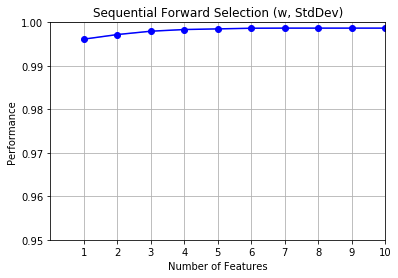

In [79]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
fig1 = plot_sfs(sfs.get_metric_dict(),
                kind = 'std_dev')
plt.ylim([.95,1])
plt.xlim(0,10)
plt.title('Sequential Forward Selection (w, StdDev)')
plt.grid()
plt.show()

### LR

In [ ]:
mydata=pd.read_csv('top30.csv',index_col = 0)
test_train = mydata[(mydata['Date']>'2010-01-14')&(mydata['Date']<'2010-09-01')].drop(columns =['Date'])
oot = mydata[mydata['Date']>='2010-09-01'].drop(columns =['Date'])
X= test_train.drop(['Fraud'],axis=1)
y = test_train['Fraud']
oot_x=oot.drop(['Fraud'],axis=1)
oot_y=oot['Fraud']

In [ ]:
def get_result(X_train,y_train,model):
    
    result = pd.DataFrame({'predicted':model.predict_proba(X_train)[:,1],'Fraud':y_train})
    topRows = int(round(len(y_train)*0.03))
    temp = result.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    temp2 = result.sort_values('predicted',ascending=True).head(topRows)
    needed2=temp2.loc[:,'Fraud']

    return max(sum(needed),sum(needed2))/sum(y_train)

In [ ]:
FDR3 = pd.DataFrame()
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(new, y, test_size = 0.40)
    scaler = StandardScaler()

    X_train_z = scaler.fit_transform(X_train)
    X_test_z = scaler.transform(X_test)
    oot_x_z = scaler.transform(new_oot_x)
    model = LogisticRegression()
    model.fit(X_train_z,y_train)

    FDR3.loc[i,'trn']=get_result(X_train_z,y_train,model)
    FDR3.loc[i,'tst']=get_result(X_test_z,y_test,model)
    FDR3.loc[i,'oot']=get_result(oot_x_z,oot_y,model)
print(FDR3.mean())
result.append([FDR3.mean()])